# Stock Market Prediction And Forecasting Using Stacked LSTM

LSTM: Long Short Term Memory

### Steps Invloved


1. Collect the Stock Data [ Apple Comp Stock Price ].
2. Preprocess the data - train and test.
3. Create and Stacked LSTM Model.
4. Predict the test data and plot the output.
5. predict the next 30 days and plot the output.  



# **pandas-datareader**:  
pandas-datareader is a remote data access for pandas, ie provides lot 
of libraries to access data. Eg. we will be using Tiingo.

* [pandas-datareader docs](https://pandas-datareader.readthedocs.io/en/latest/)



---



# **Tiingo** :
Tiingo is a tracing platform that provides a data api with historical end-of-day prices on equities, mutual funds and ETFs etc

* [Tiingo](https://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-tiingo)
*   [Tiingo Website](https://www.tiingo.com/)





# Step One : Collect the data.




In [2]:
# import data reader
import pandas_datareader as pdr

# key must be hidden
key = 'xxxxxxxxxxxxx'

# get the entire Apple data into a data frame
df = pdr.get_data_tiingo('AAPL', api_key=key)

In [3]:
df.to_csv('AAPL.csv')

In [4]:
df.head()

close    high  ...  divCash  splitFactor
symbol date                                      ...                      
AAPL   2016-06-24 00:00:00+00:00  93.40  94.655  ...      0.0          1.0
       2016-06-27 00:00:00+00:00  92.04  93.050  ...      0.0          1.0
       2016-06-28 00:00:00+00:00  93.59  93.660  ...      0.0          1.0
       2016-06-29 00:00:00+00:00  94.40  94.550  ...      0.0          1.0
       2016-06-30 00:00:00+00:00  95.60  95.770  ...      0.0          1.0

[5 rows x 12 columns]

In [5]:
df.tail()

close    high  ...  divCash  splitFactor
symbol date                                       ...                      
AAPL   2021-06-16 00:00:00+00:00  130.15  130.89  ...      0.0          1.0
       2021-06-17 00:00:00+00:00  131.79  132.55  ...      0.0          1.0
       2021-06-18 00:00:00+00:00  130.46  131.51  ...      0.0          1.0
       2021-06-21 00:00:00+00:00  132.30  132.41  ...      0.0          1.0
       2021-06-22 00:00:00+00:00  133.98  134.08  ...      0.0          1.0

[5 rows x 12 columns]

## Performing stock prediction on the close column

In [6]:
# reseting the index. ie giving index values
df_1 = df.reset_index()

In [7]:
df_1.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2016-06-24 00:00:00+00:00,93.40,94.655,92.65,92.91,75311356,21.810156,22.103215,21.635021,21.695734,301245424,0.0,1.0
1,AAPL,2016-06-27 00:00:00+00:00,92.04,93.050,91.50,93.00,46622188,21.492578,21.728426,21.366480,21.716751,186488752,0.0,1.0
2,AAPL,2016-06-28 00:00:00+00:00,93.59,93.660,92.14,92.90,40444914,21.854524,21.870870,21.515929,21.693399,161779656,0.0,1.0
3,AAPL,2016-06-29 00:00:00+00:00,94.40,94.550,93.63,93.97,36531006,22.043669,22.078696,21.863864,21.943259,146124024,0.0,1.0
4,AAPL,2016-06-30 00:00:00+00:00,95.60,95.770,94.30,94.44,35836356,22.323886,22.363583,22.020318,22.053010,143345424,0.0,1.0


In [8]:
# Pick up close column
df_1 = df.reset_index()['close']

In [9]:
df_1.shape

(1257,)

## plotting the data frame

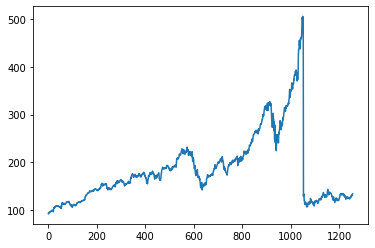

In [10]:
import matplotlib.pyplot as plt
plt.plot(df_1)

In [11]:
df_1

0        93.40
1        92.04
2        93.59
3        94.40
4        95.60
         ...  
1252    130.15
1253    131.79
1254    130.46
1255    132.30
1256    133.98
Name: close, Length: 1257, dtype: float64

### LSTM is very sensitive to scalar data eg. 129.67
### so we convert it into min max scalar which transform data between 0-1. 

In [12]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [13]:
# https://stackoverflow.com/questions/18691084/what-does-1-mean-in-numpy-reshape

scalar = MinMaxScaler(feature_range=(0,1)) # scaling value
df_1 = scalar.fit_transform(np.array(df_1).reshape(-1,1))  # reshape to provide input to fit_Transform

In [14]:
df_1.shape

(1257, 1)

In [15]:
df_1

array([[0.00328463],
       [0.        ],
       [0.00374351],
       ...,
       [0.09279073],
       [0.09723463],
       [0.10129211]])

# Step 2 :  Preprocess the data



This is a time series data.

Cross validation and random seed works well on linear data.

So for time series data we got to process by dividing the data into train and test.

eg. 70% data is the training data and 30% data is our test data.



### 1.   Splitting the data into train and test



In [18]:
training_data_size = int(len(df_1)*0.70)
print(training_data_size)

# training data size is 70% of the data frame
# testing data size is 30% of data frame
testing_data_size= len(df_1) - training_data_size
print(testing_data_size)

879
378


In [21]:
# 0 to 879 will be training data
training_data = df_1[0:training_data_size] 
print(len(training_data))

879


In [22]:
# from 879 to end will be test data
testing_data = df_1[training_data_size : len(df_1)]
print(len(testing_data))

378



## 2.   Calculate X_data , y_data



In [61]:
def create_dataset(dataset , number_of_independent_feature = 1):
  X_data, y_data = [], []

  print(len(dataset)) # 879
  print(number_of_independent_feature-1) # 99
  print(len(dataset)-number_of_independent_feature-1) # 778

  for i in range(len(dataset)-number_of_independent_feature-1):
    # for i in range(778) will go upto 777
    sliced_dataset = dataset[i:(i+number_of_independent_feature),0] # 0 is the axis
    # print(sliced_dataset)
    X_data.append(sliced_dataset)
    y_data.append(dataset[i+number_of_independent_feature,0])
  
  return np.array(X_data), np.array(y_data)

In [62]:
number_of_independent_feature = 100
X_train, y_train = create_dataset(training_data, number_of_independent_feature)
X_test, y_test = create_dataset(testing_data, number_of_independent_feature)

879
99
778
378
99
277


In [65]:
# print("X_train data is: ",X_train)
# print('\n')
# print("y_train data is: ",y_train)

In [66]:
# print("X_test data is: ",X_test)
# print('\n')
# print("y_test data is: ",y_test)

In [67]:
print(X_train.shape)
print(y_train.shape)

(778, 100)
(778,)


In [68]:
print(X_test.shape)
print(y_test.shape)

(277, 100)
(277,)


# Step 3: Create and Stacked LSTM Model.

The input to every LSTM layer must be three-dimensional.

The three dimensions of this input are:

Samples. One sequence is one sample. A batch is comprised of one or more samples.

Time Steps. One time step is one point of observation in the sample.

Features. One feature is one observation at a time step.


#### Before creating any LSTM model we have to reshape out X train and X test.

#### Our X data set is in 2 dimension. Convert it into 3D by adding 1.

### third dimension will be our feature.

In [72]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)

In [74]:
print(X_train.shape)
print(X_test.shape)

(778, 100, 1)
(277, 100, 1)




##    Create Stacked LSTM Model



In [75]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [76]:
model = Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # X train shape is 778,100,1 so we give 100, 1
# stacked LSTM. One layer after the other
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [78]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=100, batch_size=64, verbose=2)

Epoch 1/100
13/13 - 8s - loss: 0.0113 - val_loss: 0.0404
Epoch 2/100
13/13 - 2s - loss: 0.0026 - val_loss: 0.0267
Epoch 3/100
13/13 - 2s - loss: 0.0010 - val_loss: 0.0241
Epoch 4/100
13/13 - 2s - loss: 5.8090e-04 - val_loss: 0.0258
Epoch 5/100
13/13 - 2s - loss: 4.4860e-04 - val_loss: 0.0261
Epoch 6/100
13/13 - 2s - loss: 4.2794e-04 - val_loss: 0.0243
Epoch 7/100
13/13 - 2s - loss: 4.0249e-04 - val_loss: 0.0237
Epoch 8/100
13/13 - 2s - loss: 3.9892e-04 - val_loss: 0.0241
Epoch 9/100
13/13 - 2s - loss: 3.8937e-04 - val_loss: 0.0239
Epoch 10/100
13/13 - 2s - loss: 3.7335e-04 - val_loss: 0.0244
Epoch 11/100
13/13 - 2s - loss: 3.8941e-04 - val_loss: 0.0230
Epoch 12/100
13/13 - 2s - loss: 3.7640e-04 - val_loss: 0.0219
Epoch 13/100
13/13 - 2s - loss: 3.6524e-04 - val_loss: 0.0219
Epoch 14/100
13/13 - 2s - loss: 3.3935e-04 - val_loss: 0.0222
Epoch 15/100
13/13 - 2s - loss: 3.3325e-04 - val_loss: 0.0218
Epoch 16/100
13/13 - 2s - loss: 3.2692e-04 - val_loss: 0.0229
Epoch 17/100
13/13 - 2s - los

# Step 4 : Predict the test data and plot the output.

In [81]:
import tensorflow as tf

In [82]:
## Prediction
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

In [86]:
# print("prediction on X train is: ",train_predict)
# print("\n")
# print("prediction on X_test is",test_predict)

In [87]:
# we had used Min max scalar so we got to inverse it back to original form

train_predict = scalar.inverse_transform(train_predict)
test_predict = scalar.inverse_transform(test_predict)

## Regression Metrics for Machine Learning:

*   Regression refers to predictive modeling problems that involve predicting a numeric value.
*   Predictive modeling is the problem of developing a model using historical data to make a prediction on new data where we do not have the answer.


---


### Metrics for Regression:
*   Mean Squared Error : Mean Squared Error, or MSE for short, is a popular error metric for regression problems.

-   mean_squared_error(expected, predicted)

---



[Regression Metrics](https://machinelearningmastery.com/regression-metrics-for-machine-learning/)

In [92]:
import math
from sklearn.metrics import mean_squared_error

In [93]:
# for train data set
(math.sqrt(mean_squared_error(y_train, train_predict)))

183.38360784987665

In [94]:
# for test data
math.sqrt(mean_squared_error(y_test, test_predict))

238.19489202639727


### Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras 

Because of how the dataset was prepared, we must shift the predictions so that they align on the x-axis with the original dataset. Once prepared, the data is plotted, showing the original dataset in blue, the predictions for the training dataset in green, and the predictions on the unseen test dataset in red.


[Plotting](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)



---



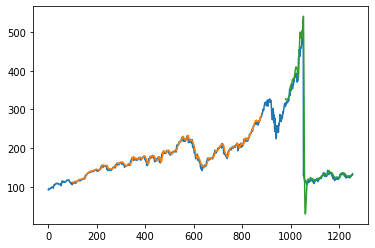

In [98]:
# plotting
# time step is same as look_back. 99 independent and 1 dependent feature
look_back = 100
# shift train predictions for plotting
trainPredictPlot = np.empty_like(df_1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df_1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df_1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scalar.inverse_transform(df_1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

# Step 5: predict the next 30 days and plot the output.

In [99]:
# for getting 31 day prediction i need to have previous 30days

len(testing_data)

378

In [109]:
X_input = testing_data[278:].reshape(1,-1)

In [110]:
X_input.shape

(1, 100)

In [112]:
X_input

array([[0.09641348, 0.10167854, 0.10373143, 0.10119551, 0.10952783,
        0.10800628, 0.10836855, 0.1061949 , 0.1046975 , 0.10406956,
        0.1046492 , 0.09938413, 0.09370849, 0.09097935, 0.09136578,
        0.08201908, 0.08168096, 0.08044922, 0.06991909, 0.07057119,
        0.08634223, 0.07989373, 0.07250332, 0.06784205, 0.07095761,
        0.05873687, 0.07014853, 0.06747977, 0.0722618 , 0.0700157 ,
        0.07716459, 0.08098056, 0.07902427, 0.06880811, 0.06750392,
        0.07571549, 0.0736626 , 0.06774544, 0.06895302, 0.07045043,
        0.07088516, 0.06728656, 0.07272069, 0.07477358, 0.08177756,
        0.08252626, 0.0866079 , 0.09254921, 0.09891317, 0.09467456,
        0.10237894, 0.09658254, 0.102548  , 0.10172684, 0.10336916,
        0.09919092, 0.10013283, 0.09636517, 0.10211327, 0.10307934,
        0.10228233, 0.10032605, 0.10008453, 0.09520589, 0.09781427,
        0.08648714, 0.08709093, 0.09105181, 0.09218693, 0.08407197,
        0.08180171, 0.07421809, 0.07953146, 0.08

In [114]:
# converting into a list.
temp_input = list(X_input)
print(temp_input)

[array([0.09641348, 0.10167854, 0.10373143, 0.10119551, 0.10952783,
       0.10800628, 0.10836855, 0.1061949 , 0.1046975 , 0.10406956,
       0.1046492 , 0.09938413, 0.09370849, 0.09097935, 0.09136578,
       0.08201908, 0.08168096, 0.08044922, 0.06991909, 0.07057119,
       0.08634223, 0.07989373, 0.07250332, 0.06784205, 0.07095761,
       0.05873687, 0.07014853, 0.06747977, 0.0722618 , 0.0700157 ,
       0.07716459, 0.08098056, 0.07902427, 0.06880811, 0.06750392,
       0.07571549, 0.0736626 , 0.06774544, 0.06895302, 0.07045043,
       0.07088516, 0.06728656, 0.07272069, 0.07477358, 0.08177756,
       0.08252626, 0.0866079 , 0.09254921, 0.09891317, 0.09467456,
       0.10237894, 0.09658254, 0.102548  , 0.10172684, 0.10336916,
       0.09919092, 0.10013283, 0.09636517, 0.10211327, 0.10307934,
       0.10228233, 0.10032605, 0.10008453, 0.09520589, 0.09781427,
       0.08648714, 0.08709093, 0.09105181, 0.09218693, 0.08407197,
       0.08180171, 0.07421809, 0.07953146, 0.08552107, 0.0826

In [115]:
temp_input = temp_input[0].tolist() # Pandas tolist() is used to convert a series to list.
print(temp_input)

[0.09641347663325686, 0.10167854123898076, 0.10373143340176308, 0.10119550778891437, 0.10952783480256004, 0.10800627943485083, 0.10836855452240066, 0.10619490399710177, 0.10469750030189587, 0.10406955681680954, 0.10464919695688926, 0.0993841323511653, 0.09370848931288492, 0.09097935032000967, 0.0913657770800628, 0.08201907982127762, 0.0816809564062311, 0.08044922110856176, 0.06991909189711384, 0.07057118705470353, 0.0863422291993721, 0.0798937326409854, 0.07250332085496922, 0.06784204806182828, 0.07095761381475665, 0.0587368675280763, 0.07014853278589542, 0.06747977297427846, 0.07226180412993596, 0.07001569858712717, 0.0771645936481101, 0.08098055790363481, 0.07902427243086582, 0.06880811496196113, 0.06750392464678176, 0.07571549329791086, 0.0736626011351286, 0.06774544137181501, 0.06895302499698105, 0.0704504286921869, 0.07088515879724669, 0.06728655959425192, 0.07272068590749911, 0.07477357807028137, 0.08177756309624443, 0.08252626494384732, 0.0866078975969086, 0.09254920903272554, 0

In [124]:
# predicting for next 30 days

from numpy import array

list_output = []
n_steps = 100
i = 0

# calulate for 30 days
while(i<30):

  if(len(temp_input) > 100 ):
    # when my temp_input has more than one 100 value then start from 1 to end. ie 1 to 101
    X_input = np.array(temp_input[1:])
    print("{} day input is {} (100)".format(i,X_input))
    print("\n")

    # we got to reshape before performing prediction
    X_input = X_input.reshape(1,-1) # New shape as (1,-1). i.e, row is 1, column unknown.
    X_input = X_input.reshape((1,n_steps,1))

    print("X_input for greater than 100 is",X_input)
    print("\n")

    y_hat = model.predict(X_input,verbose=0)
    print("{} day input is {} (100)".format(i,y_hat))
    print("\n")

    temp_input.extend(y_hat[0].tolist())

    temp_input = temp_input[1:]

    print("temp input is(100): ", temp_input)
    print("\n")


    list_output.extend(y_hat.tolist())

    i += 1

  else:
    X_input = X_input.reshape((1,n_steps,1))
    y_hat = model.predict(X_input,verbose=0)

    print("{} day input is {}".format(i,y_hat))
    print("\n")

    temp_input.extend(y_hat[0].tolist())

    print("temp input is: ", temp_input)
    print("\n")


    list_output.extend(y_hat.tolist())

    i += 1 

print("Print the list output is: ",list_output)




0 day input is [0.09520589 0.09781427 0.08648714 0.08709093 0.09105181 0.09218693
 0.08407197 0.08180171 0.07421809 0.07953146 0.08552107 0.08267117
 0.07924164 0.07885521 0.08518295 0.08064243 0.08467576 0.08419273
 0.08407197 0.08028016 0.078662   0.07786499 0.07974882 0.07607777
 0.08175341 0.08177756 0.0838063  0.08474822 0.08228475 0.08527956
 0.09283903 0.09081029 0.09204202 0.0960029  0.09279073 0.09723463
 0.10129211 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292 0.09953292
 0.09953292 0.09953292 0.09953292 0.09953292 0.

# Plotting

In [125]:
# test day has previous 100 days
day = np.arange(1,101)
# have to predict next 100 days
day_pred = np.arange(101,131)

In [126]:
import matplotlib.pyplot as plt

In [127]:
len(df_1)

1257

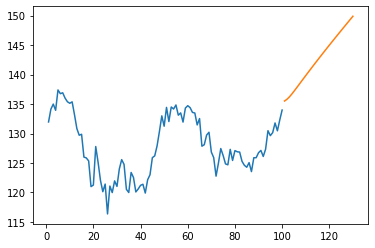

In [128]:
# 1157 because total length of data frame is 1257. and we have taken the previous 100 data
# so previous 100 means it start from 1157 to 1257
plt.plot(day,scalar.inverse_transform(df_1[1157: ]))
plt.plot(day_pred,scalar.inverse_transform(list_output))

# the orange line shows the prediction

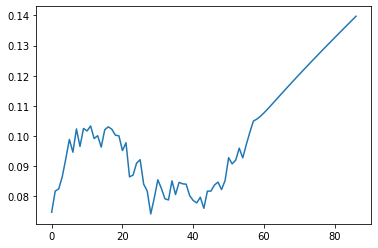

In [134]:
# complete op

df_2 = df_1.tolist()
df_2.extend(list_output)
plt.plot(df_2[1200: ])